In [75]:
import numpy as np
from glm_utils import *
import glm_model as gm
import tensorflow as tf

#the autoreload extension allows modules to reload if they are changed. Otherwise we would need
#to restart the kernel in order for changes to our custom modules to take effect. 

%load_ext autoreload
%autoreload 2

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<font face = "Computer Modern", size = 3>

Here we generate data from poisson, gaussian, and exponential noise models. We use helper functions from the glm_utils module to generate this data, and stick with the default parameters:
<ul>
    <li>T = 1000 (number of time points simulated)</li>
    <li>n = 30 (number of features)</li>
    <li>eps = 1e-4 (for numerical stability)</li>
    <li>c = 3 (offset)</li>
    <li>scale = 5 (scale on non-linearity)</li>
    <li>filt_amp = 10 (amplitude of the gaussian shaped filter)</li>
    
</ul>
In each case, data is both generated and fit with a sigmoidal non-linearity (although it's easy to see how we could change that on the fly). 

We iterate through generating data, and fit the corresponding GLM. 


To Do: the plotting code is a bit ugly, and the spacing isn't right... I'll fix this in future versions. Also should add a markdown cell that specifies the logloss for each of the distributions. 

generating gaussian data...
fitting gaussian model...
generating poisson data...
fitting poisson model...
generating exponential data...
fitting exponential model...
plotting...


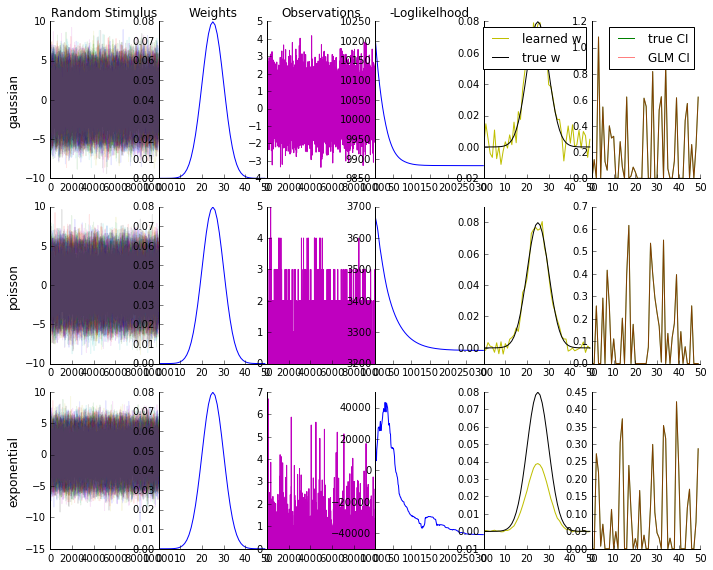

In [84]:
noise_models = {'poisson':gm.poisson_GLM, 'gaussian': gm.gaussian_GLM, 'exponential':gm.exponential_GLM}

plt.figure(figsize = [10, 8])

gs, ax = gridplot(3, 6)

i = 0
for nm in noise_models:
    
    print "generating " + nm + " data..."
    
    #get the stimulus, weights, and simulated observations for each noise model 
    stim, weights, y = generate_data(noise_model = nm, non_lin = relu, T = 10000, n = 50, c = 0, filt_amp=1, scale = 1)
    
    #plot the stimulus, weights, and observations (first plot only the first stimulus feature, so that only one label
    #shows
   
    if ax[i].is_first_col():
        ax[i].set_ylabel(nm, fontsize = 12)
 
    ax[i].plot(stim, alpha = .1);
    if ax[i].is_first_row():
        ax[i].set_title('Random Stimulus', fontsize = 12)        
    simpleaxis(ax[i])   

    ax[i + 1].plot(weights)
    if ax[i + 1].is_first_row():
        ax[i + 1].set_title('Weights', fontsize = 12)
        
    simpleaxis(ax[i + 1])
    ax[i + 2].plot(y, c = 'm')
    if ax[i + 2].is_first_row():
        ax[i + 2].set_title('Observations', fontsize = 12)
    simpleaxis(ax[i + 2])
    i+= 3
    
    #fit the glm    
    weight_init = np.linalg.pinv(stim).dot(y)
    
    print "fitting " + nm + " model..."
    model = noise_models[nm](weight_init.reshape([50, 1]), lr = .5e-3, verbose = False, non_lin = tf.nn.relu, alpha = 0, 
                             train_params = False, scale_init = 1, bias_init = 0)
    
    L, l = model.fit(stim, y[: ,np.newaxis], stim, y[:, np.newaxis], batch_size = 1000, max_iters = 300)
    
    #plot the negative log-liklihood and learned weights
    ax[i].plot(L)
    if ax[i].is_first_row():
        ax[i].set_title('-Loglikelhood', fontsize = 12)
    
    simpleaxis(ax[i])
    
    w_, o_, s_ = model.get_params()
    ax[i+ 1].plot(w_, 'y', label = 'learned w')
    ax[i+ 1].plot(weights, 'k', label = 'true w')
    if ax[i+ 1].is_first_row():
        ax[i+1].legend()
    simpleaxis(ax[i+1])
    
    
    ax[i+ 2].plot(model.predict_trace(stim)[0:50], 'g', label = 'true CI')
    ax[i+ 2].plot(model.predict_trace(stim)[0:50], 'r', label = 'GLM CI', alpha = .5)
    if ax[i+ 2].is_first_row():
        ax[i+2].legend()
    simpleaxis(ax[i+2]) 
    
    i+=3    
    
print "plotting..."
plt.tight_layout()
plt.show()   
